# Appendix 10.4.5: Using Haiku as a sub-agent

In this recipe, we'll demonstrate how to analyze Apple's 2023 financial earnings reports using Claude 3 Haiku sub-agent models to extract relevant information from earnings release PDFs. We'll then use Claude 3 Sonnet to generate a response to our question and create a graph using matplotlib to accompany its response.

## Step 1: Set up the environment
First, let's install the required libraries and set up the Anthropic API client.

In [1]:
pip install -qUr requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import the required libraries
import boto3
import fitz
from PIL import Image
import io
from concurrent.futures import ThreadPoolExecutor
import requests
import os

session = boto3.Session()
region = session.region_name

modelId = 'anthropic.claude-3-sonnet-20240229-v1:0'
#modelId = 'anthropic.claude-3-haiku-20240307-v1:0'

print(f'Using modelId: {modelId}')
print('Using region: ', region)

bedrock_client = boto3.client(service_name = 'bedrock-runtime', region_name = region,)

Using modelId: anthropic.claude-3-sonnet-20240229-v1:0
Using region:  us-west-2


## Step 2: Gather our documents and ask a question
For this example, we will be using all Apple's financial statements from the 2023 financial year and asking about the net sales over the year.

In [3]:
# List of Apple's earnings release PDF URLs
pdf_urls = [
    "https://www.apple.com/newsroom/pdfs/fy2023-q4/FY23_Q4_Consolidated_Financial_Statements.pdf",
    "https://www.apple.com/newsroom/pdfs/fy2023-q3/FY23_Q3_Consolidated_Financial_Statements.pdf",
    "https://www.apple.com/newsroom/pdfs/FY23_Q2_Consolidated_Financial_Statements.pdf",
    "https://www.apple.com/newsroom/pdfs/FY23_Q1_Consolidated_Financial_Statements.pdf"
]

# User's question
QUESTION = "How did Apple's net sales change quarter to quarter in the 2023 financial year and what were the key contributors to the changes?"

## Step 3: Download and convert PDFs to images
Next, we'll define functions to download the earnings release PDFs and convert them to base64-encoded PNG images. We have to do this because these PDFs are full of tables that are hard to parse with traditional PDF parsers. It's easier if we just convert them to images and pass the images to Haiku.

The ```download_pdf``` function downloads a PDF file from a given URL and saves it to the specified folder. The ```pdf_to_pngs``` function converts a PDF to a list of PNG images.

In [4]:
# Function to download a PDF file from a URL and save it to a specified folder
def download_pdf(url, folder):
    response = requests.get(url)
    if response.status_code == 200:
        file_name = os.path.join(folder, url.split("/")[-1])
        with open(file_name, "wb") as file:
            file.write(response.content)
        return file_name
    else:
        print(f"Failed to download PDF from {url}")
        return None
    
# Define the function to convert a PDF to a list of base64-encoded PNG images
def pdf_to_png(pdf_path, quality=75, max_size=(1024, 1024)):
    # Open the PDF file
    doc = fitz.open(pdf_path)
    pdf_to_png_images = []

    # Iterate through each page of the PDF
    for page_num in range(doc.page_count):
        # Load the page
        page = doc.load_page(page_num)

        # Render the page as a PNG image
        pix = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72))

        # Convert the pixmap to a PIL Image
        image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

        # Resize the image if it exceeds the maximum size
        if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
            image.thumbnail(max_size, Image.Resampling.LANCZOS)

        # Convert the PIL image to bytes
        image_data = io.BytesIO()
        image.save(image_data, format='PNG', optimize=True, quality=quality)
        image_data.seek(0)
        pdf_to_png_image = image_data.getvalue()

        # Append the PNG image bytes to the list
        pdf_to_png_images.append(pdf_to_png_image)

    # Close the PDF document
    doc.close()

    return pdf_to_png_images

# Folder to save the downloaded PDFs
folder = "./images/using_sub_agents"

# Download the PDFs concurrently
with ThreadPoolExecutor() as executor:
    pdf_paths = list(executor.map(download_pdf, pdf_urls, [folder] * len(pdf_urls)))

# Remove any None values (failed downloads) from pdf_paths
pdf_paths = [path for path in pdf_paths if path is not None]

We use ThreadPoolExecutor to download the PDFs concurrently and store the file paths in pdf_paths.

## Step 4: Generate a specific prompt for Haiku using Sonnet
Let's use Opus as an orchestrator and have it write a specific prompt for each Haiku sub-agent based on the user provided question.

In [5]:
def generate_haiku_prompt(question):
    prompt = f"""Based on the following question, please generate a specific prompt for an LLM sub-agent to extract relevant information from an earning's report PDF. Each sub-agent only has access to a single quarter's earnings report. Output only the prompt and nothing else.\n\nQuestion: {question}"""
    messages = [
        {
            "role": 'user',
            "content": [
                {"text": prompt }
            ]
        }
    ]

    converse_api_params = {
        "modelId": modelId,
        "messages": messages,
    }

    response = bedrock_client.converse(**converse_api_params)

    return response['output']['message']['content'][0]['text']

haiku_prompt = generate_haiku_prompt(QUESTION)
print(haiku_prompt)

Extract the net sales figures for each quarter of Apple's 2023 fiscal year from the income statement or consolidated statement of operations. Identify and summarize the key factors mentioned in the report that drove any significant increases or decreases in net sales quarter-over-quarter, such as sales performance of major product lines, geographic regions, or other business segments.


## Step 5: Extract information from PDFs
Now, let's define our question and extract information from the PDFs using sub-agent Haiku models. We format the information from each model into a neatly defined set of XML tags.

In [6]:
def extract_info(pdf_path, haiku_prompt):
    pdf_pngs = pdf_to_png(pdf_path)

    messages = [
        {
            "role": "user",
            "content": [
                *[{"image": {"format": 'png', "source": {"bytes": pdf_png}}} for pdf_png in pdf_pngs],
                {"text": haiku_prompt}
            ]
        }
    ]

    converse_api_params = {
        "modelId": "anthropic.claude-3-haiku-20240307-v1:0",
        "messages": messages,
    }
    response = bedrock_client.converse(**converse_api_params)

    return response['output']['message']['content'][0]['text'], pdf_path

def process_pdf(pdf_path):
    return extract_info(pdf_path, QUESTION)

# Process the PDFs concurrently with Haiku sub-agent models
with ThreadPoolExecutor() as executor:
    extracted_info_list = list(executor.map(process_pdf, pdf_paths))

extracted_info = ""
# Display the extracted information from each model call
for info in extracted_info_list:
    extracted_info += "<info quarter=\"" + info[1].split("/")[-1].split("_")[1] + "\">" + info[0] + "</info>\n"
print(extracted_info)

<info quarter="Q4">Based on the Condensed Consolidated Statements of Operations in the image, Apple's net sales changed as follows in the 2023 financial year:

- For the three months ended September 30, 2023, net sales were $89,498 million, compared to $90,146 million for the three months ended September 24, 2022. This represents a decrease of $648 million or 0.7% quarter-over-quarter.

- The key contributors to this change were:
    - Decreases in products sales from $70,958 million to $67,184 million (-$3,774 million or -5.3%)
    - Increases in services sales from $19,188 million to $22,314 million (+$3,126 million or +16.3%)

So the overall decrease in net sales was driven by lower product sales, partially offset by higher services sales, between the two quarters in the 2023 fiscal year.</info>
<info quarter="Q3">According to the financial statements, Apple's net sales increased quarter-over-quarter in the 2023 financial year:

- In the three months ended July 1, 2023, net sales we

We extract information from the PDFs concurrently using sub-agent models and combine the extracted information. We then prepare the messages for the powerful model, including the question and the extracted information, and ask it to generate a response and matplotlib code.

## Step 6: Pass the information to Sonnet to generate a response
Now that we have fetched the information from each PDF using the sub-agents, let's call Opus to actually answer the question and write code to create a graph to accompany the answer.

In [7]:
# Prepare the messages for the powerful model
messages = [
    {
        "role": "user",
        "content": [
            {"text": f"Based on the following extracted information from Apple's earnings releases, please provide a response to the question: {QUESTION}\n\nAlso, please generate Python code using the matplotlib library to accompany your response. Enclose the code within <code> tags.\n\nExtracted Information:\n{extracted_info}"}
        ]
    }
]

# Generate the matplotlib code using the powerful model
converse_api_params = {
    "modelId": "anthropic.claude-3-sonnet-20240229-v1:0",
    "messages": messages,
    "inferenceConfig": {"maxTokens": 4096},
}
response = bedrock_client.converse(**converse_api_params)

generated_response = response['output']['message']['content'][0]['text']
print("Generated Response:")
print(generated_response)

Generated Response:
Apple's net sales experienced fluctuations quarter-over-quarter in the 2023 financial year, driven by changes in both product and services sales. Here's a breakdown of the key movements and contributors:

1. Q4 2023 vs Q3 2023:
   - Net sales decreased by $648 million or 0.7% quarter-over-quarter.
   - Product sales decreased by $3,774 million or 5.3%, contributing to the overall decline.
   - Services sales increased by $3,126 million or 16.3%, partially offsetting the decrease in product sales.

2. Q3 2023 vs Q2 2023:
   - Net sales increased significantly by over $210 billion quarter-over-quarter.
   - Product sales grew substantially from $63,355 million to $230,901 million, driving the overall increase.
   - Services revenue also increased from $19,604 million to $62,886 million, contributing to the net sales growth.

3. Q2 2023 vs Q1 2023:
   - Net sales increased quarter-over-quarter.
   - Product sales increased from $107,560 million to $113,599 million, con

## Step 7: Extract response and execute Matplotlib code
Finally, let's extract the matplotlib code from the generated response and execute it to visualize the revenue growth trend.

We define the ```extract_code_and_response``` function to extract the matplotlib code and non-code response from the generated response. We print the non-code response and execute the matplotlib code if it is found.

Note that it is not good practice to use ```exec``` on model-written code outside of a sandbox but for the purposes of this demo we are doing it :)

Apple's net sales experienced fluctuations quarter-over-quarter in the 2023 financial year, driven by changes in both product and services sales. Here's a breakdown of the key movements and contributors:

1. Q4 2023 vs Q3 2023:
   - Net sales decreased by $648 million or 0.7% quarter-over-quarter.
   - Product sales decreased by $3,774 million or 5.3%, contributing to the overall decline.
   - Services sales increased by $3,126 million or 16.3%, partially offsetting the decrease in product sales.

2. Q3 2023 vs Q2 2023:
   - Net sales increased significantly by over $210 billion quarter-over-quarter.
   - Product sales grew substantially from $63,355 million to $230,901 million, driving the overall increase.
   - Services revenue also increased from $19,604 million to $62,886 million, contributing to the net sales growth.

3. Q2 2023 vs Q1 2023:
   - Net sales increased quarter-over-quarter.
   - Product sales increased from $107,560 million to $113,599 million, contributing to the ove

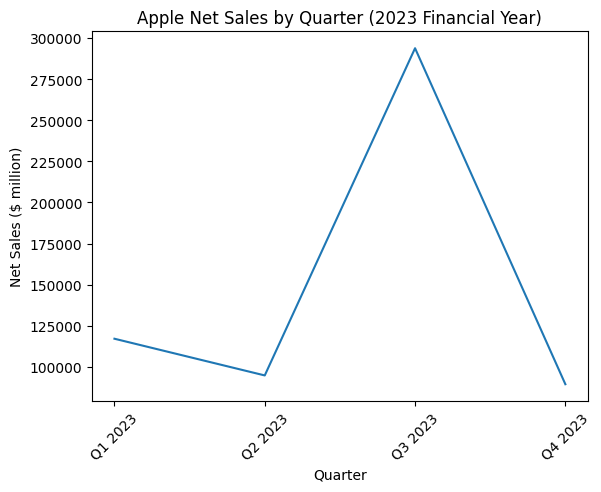

In [8]:
# Extract the matplotlib code from the response
# Function to extract the code and non-code parts from the response
def extract_code_and_response(response):
    start_tag = "<code>"
    end_tag = "</code>"
    start_index = response.find(start_tag)
    end_index = response.find(end_tag)
    if start_index != -1 and end_index != -1:
        code = response[start_index + len(start_tag):end_index].strip()
        non_code_response = response[:start_index].strip()
        return code, non_code_response
    else:
        return None, response.strip()

matplotlib_code, non_code_response = extract_code_and_response(generated_response)

print(non_code_response)
if matplotlib_code:

    # Execute the extracted matplotlib code
    exec(matplotlib_code)
else:
    print("No matplotlib code found in the response.")